# Markov Chain: Forecasting the Next 25 States

### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import random as rm
import mchmm as mc
import math
from sklearn.metrics import classification_report
import re

### Prepare Data

In [2]:
# file names
## training
### subjects 1-30
train_subject_f = "UCI_HAR_Dataset/train/subject_train.txt"
### classification 
y_train_f = "UCI_HAR_Dataset/train/y_train.txt"

## testing
### subjects 1-30
test_subject_f = "UCI_HAR_Dataset/test/subject_test.txt"
### classification 
y_test_f = "UCI_HAR_Dataset/test/y_test.txt"

In [3]:
# training data frames
train_subject_df = pd.read_csv(train_subject_f, sep=' ', header=None)
y_train_df = pd.read_csv(y_train_f, sep=' ', header=None, names=["State"])

# testing dataframes
test_subject_df = pd.read_csv(test_subject_f, sep=' ', header=None)
y_test_df = pd.read_csv(y_test_f, sep=' ', header=None, names=["State"])

In [4]:
# combine subject information with training/testing data frames
y_train_df.insert(0, "Subject", train_subject_df)
y_test_df.insert(0, "Subject", test_subject_df)

In [5]:
# combine testing and training data frames into one
all_data = pd.concat([y_train_df, y_test_df], axis=0)

### Building a Markov Chain Model Per Subject

In [6]:
# empty dataframe for predictions and original results
predictions = pd.DataFrame()
testing = pd.DataFrame()

In [7]:
# loop through each subject, create a model, and capture the predictions and AIC
for i in range(1, len(all_data["Subject"].unique())+1):
    # get all entries for given subject
    all_data_i = all_data[all_data["Subject"] == i]
    # last 25 observations as forecasting, rest is training
    i_train = all_data_i[:(np.shape(all_data_i)[0]-25)]
    i_test = all_data_i[(np.shape(all_data_i)[0]-25):]
    # record original state
    testing[str(i)] = i_test["State"].values
    # format training states into a string
    state_string = ""
    for x in i_train["State"]:
        state_string = state_string + str(x)
    # generate markov chain model
    a = mc.MarkovChain().from_data(state_string)
    # predict testing states
    ids, states = a.simulate(len(i_test["State"]), start=str(i_test.iloc[0,1]))
    # record predicted state
    predictions[str(i)] = states

### Results: Visualizations

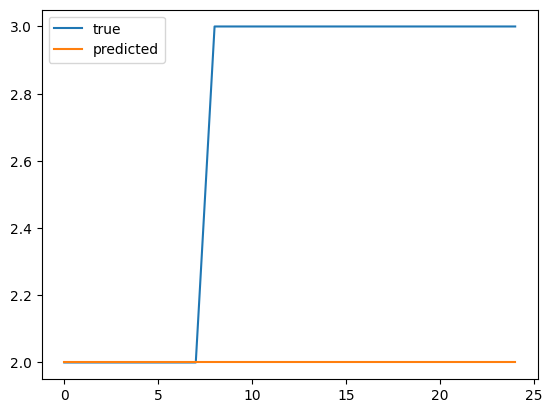

In [8]:
# view plot of an individual subject's results
s = 1
plt.plot(testing.index, testing[str(s)].astype('int'), label="true")
plt.plot(testing.index, predictions[str(s)].astype('int'), label="predicted") 
plt.legend()

In [9]:
plt.savefig("markov_25_" +str(s)+".pdf", format="pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

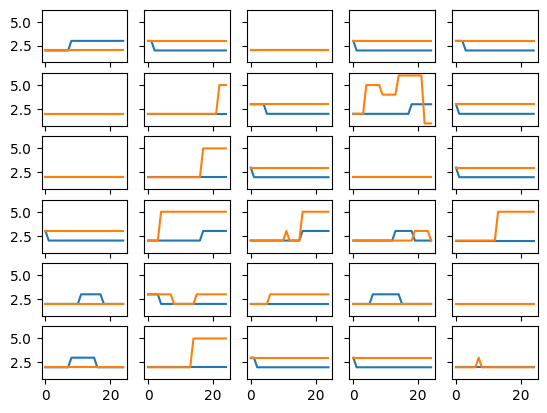

In [10]:
# view plots of results for all subjects
fig, axs = plt.subplots(6, 5, sharex=True, sharey=True)

# initialize subject 1
subject = 1
# plot each set of results
for row in range(0,6):
    for col in range(0,5):
        axs[row, col].plot(testing.index, testing[str(subject)].astype('int'), label="true")
        axs[row, col].plot(testing.index, predictions[str(subject)].astype('int'), label="predicted") 
        subject = subject + 1

# hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [11]:
fig.savefig("markov_25.pdf", format="pdf", bbox_inches="tight")

### Results: Accuracy

In [12]:
# Accuracy
# create empty dataframe to store accuracy
accuracy = pd.DataFrame()

# get accuracy using the classification report from sklearn
for i in range(1,31):
    rep_i = classification_report(testing[str(i)].astype('string'), 
                          predictions[str(i)].astype('int').astype('str'))
    acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
    accuracy.at[i,"accuracy"] = acc_i

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6g/lht9tm8x1bz3sdrs0xk_d2m00000gn/T/ipykernel_29065/810541808.py:9: SyntaxWarning: invalid escape sequence '\d'
  acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Libra

In [13]:
accuracy.mean()

accuracy    0.461333
dtype: float64

In [14]:
accuracy.describe()

,accuracy
count,30.000000
mean,0.461333
std,0.366867
min,0.040000
25%,0.090000
50%,0.480000
75%,0.710000
max,1.000000
